<a href="https://colab.research.google.com/github/Manisha2297/RestroRecommender/blob/main/Baseline%20Model%20Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model Based on Cosine Similarity Between Restaurant Characteristics

In [1]:
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib


import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns
from scipy import stats 
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval

from math import sin, cos, sqrt, atan2, radians

## Data Preparation

In [2]:
business_df = pd.read_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/restuarant_df')
business_df.shape

(56901, 14)

In [3]:
business_df = business_df.astype({'latitude':'float','longitude':'float','review_count':'int64','stars':'float'})

In [4]:
business_df.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open          object
latitude        float64
longitude       float64
name             object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

*We are building a similarity matrix based on the columns Categories, Attributes, Stars and Review Count. The DataFrame in its current form has both the Caetegories and Attributes column in string formats, and we have to convert them to lists and dictionaries respectively.*

*We create additional columns with the modified versions of the Categories and Attributes*

In [5]:
business_df['attributes'] = business_df['attributes'].fillna("{'None':'None'}") #Removing None values
business_df['attributes_edited'] = business_df['attributes'].apply(lambda x: literal_eval(x)) #Transforming the stringified dictionary to dictionary

business_df['categories_edited'] = business_df['categories'].apply(lambda x: x.split(',')) #Transforming the stringified list to list

*The edited Attributes column still has dictionaries, and we transform the column to display the attributes in the format Attribute_Attribute value*

In [102]:
attribute_keys = []
for i in business_df['attributes_edited']: #We get the dictionary keys to find out how many unique attributes are there in the data
  attribute_keys.append(list(i.keys()))

attribute_keys = [item for sublist in attribute_keys for item in sublist]

unique_keys = list(set(attribute_keys))
print('Number of unique attributes in dataset:',len(unique_keys))

Number of unique attributes in dataset: 40


In [11]:
def Attributes_Func(row): #We write this function to separate out the keys(Attributes) and their values
  xx = []
  for i in row.keys():
      xx.append(i+'_'+row[i])
  
  final_list = []
  for i in xx:
    if i.split('_')[1][0] == '{':
      continue
    else:
      final_list.append(i) 
  return(final_list)

In [12]:
business_df['Attributes_List'] = business_df['attributes_edited'].apply(lambda x: Attributes_Func(x))

# Building a Cosine Similarity Matrix

*We separate out the required columns for the Cosine Similarity calculations*

In [104]:
df_for_matrix = business_df[['business_id','Attributes_List','categories_edited']] #This is what our final DF for Count Vectorizer looks like
df_for_matrix.head()

,business_id,Attributes_List,categories_edited
0,pQeaRpvuhoEqudo3uymHIQ,"[RestaurantsAttire_u'casual', RestaurantsTakeO...","[Ethnic Food, Food Trucks, Specialty Food, ..."
1,M_guz7Dj7hX0evS672wIwA,"[BikeParking_True, Caters_True, WheelchairAcce...","[Desserts, Food, Ice Cream & Frozen Yogurt]"
2,mKTq1T_IAplDpHUcMzOXkw,[BusinessAcceptsCreditCards_True],"[Hotels & Travel, Transportation, Taxis, Be..."
3,eBEfgOPG7pvFhb2wcG9I7w,"[RestaurantsTableService_False, RestaurantsDel...","[Restaurants, Cheesesteaks, Poutineries]"
4,lu7vtrp_bE9PnxWfA8g4Pg,"[GoodForKids_True, RestaurantsTakeOut_True, Al...","[Japanese, Fast Food, Food Court, Restaurants]"


In [15]:
# df_for_matrix.to_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/Attributes_and_Characteristics')

*We clean the DataFrame so all entries in it are lower case, and we make transform each row corresponding to information about a restaurant to a string with each Category / Attribute_Attribute value separated out by spaces. This is done to be able to pass the rows into the CountVectorizer function*

In [16]:
# Function to convert all strings to lower case and strip names of spaces
#Code from Data Camp. Cleaning the text by converting to lower case
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [17]:
features = ['business_id', 'Attributes_List', 'categories_edited']

for feature in features:
    df_for_matrix[feature] = df_for_matrix[feature].apply(clean_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
def create_soup(x): #We write this function to write the data as categories and attributes separated by spaces
    return(' '.join(x['Attributes_List']) + ' ' + ' '.join(x['categories_edited']) + ' ' + x['business_id'])

In [19]:
df_for_matrix['soup'] = df_for_matrix.apply(create_soup, axis=1) #Joining values so it looks like next cell

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_for_matrix[['soup']].head(2).values #This is how our final data looks before transformation

array([["restaurantsattire_u'casual' restaurantstakeout_true businessacceptscreditcards_true noiselevel_u'quiet' goodforkids_false restaurantsreservations_false restaurantsgoodforgroups_false businessparking_none restaurantspricerange2_1 hastv_true alcohol_'none' bikeparking_false restaurantsdelivery_true byappointmentonly_false outdoorseating_false ethnicfood foodtrucks specialtyfood importedfood argentine food restaurants empanadas pqearpvuhoequdo3uymhiq"],
       ["bikeparking_true caters_true wheelchairaccessible_true restaurantspricerange2_1 wifi_u'no' businessacceptscreditcards_true restaurantstakeout_true desserts food icecream&frozenyogurt m_guz7dj7hx0evs672wiwa"]],
      dtype=object)

In [21]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_for_matrix['soup']) #Creating Count Vectorizer matrix

In [22]:
count_matrix.shape

(56901, 72150)

*This count_matrix has transformed the text fields into a sparse matrix with 56901 rows -- corresponding to the number of restaurants in our data -- and 72150 columns -- corresponding to unique charateristics of each row--*

*We still need to incorporate user ratings of the restaurants, which we do below*

In [23]:
Stars = business_df[['review_count','stars']]

In [24]:
# sns.set_style("whitegrid")
# sns.displot(data=Stars, x='review_count')
# plt.yscale("log")
# plt.xscale("log")

*The technique we use for normalizing user ratings based on number of reviews is cooperated from the IMDB rating system. This is how it works:*
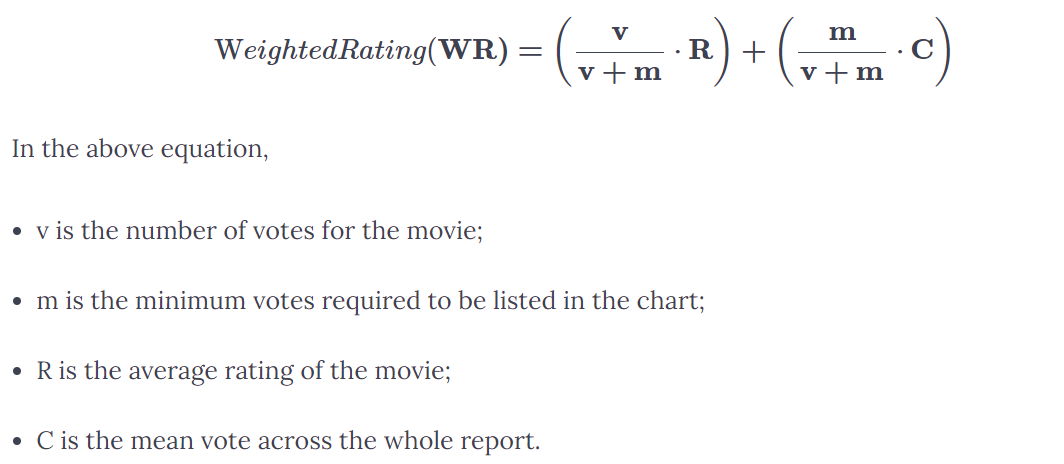


In [25]:
C = Stars['stars'].mean()
m = 50
# Function that computes the weighted rating of each restaurant
def weighted_rating(x, m=m, C=C):
    v = x['review_count']
    R = x['stars']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Stars['score'] = Stars.apply(weighted_rating, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


*We append this weighted rating column to the CountVectorizer matrix*






In [26]:
count_matrix = hstack([count_matrix,np.array(Stars['score'])[:,None]]) #We add the weighted rating column to the vectorizer matrix
count_matrix.shape

(56901, 72151)

In [29]:
# def cosine_similarity_n_space(m1, m2, batch_size=10):
#     ret = np.ndarray((m1.shape[0], m2.shape[0]))
#     for row_i in range(0, int(m1.shape[0] / batch_size) + 1):
#         start = row_i * batch_size
#         end = min([(row_i + 1) * batch_size, m1.shape[0]])
#         if end <= start:
#             break # cause I'm too lazy to elegantly handle edge cases
#         rows = m1[start: end]
#         sim = cosine_similarity(rows, m2) # rows is O(1) size
#         ret[start: end] = sim
#         del sim
#     return ret

In [30]:
# cosine_sim2 = cosine_similarity_n_space(count_matrix, count_matrix)

In [ ]:
indices = pd.Series(df_for_matrix.index, index=df_for_matrix['business_id']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim): #Function to extract restaurant recommendations from Cosine Similarity matrix
    # Get the index of the restaurant that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all restaurants with that restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 20 most similar restaurants
    sim_scores = sim_scores[1:21]

    # Get the restaurant indices
    restaurant_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar restaurants
    return df_for_matrix['business_id'].iloc[restaurant_indices]

# Modifying the Cosine Similarity Matrix into a usable form

*The recommendation matrix that we have has all 56901 restaurants as row indices and their 20 most similar restaurants in the columns*

*We further consider the top 10 restaurants based on how close the restaurants are*

In [105]:
# !pip install pickle5
import pickle5 as pickle
# recommendations_df = pd.read_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/top20_bid_df')
with open('/content/drive/MyDrive/YelpDataset/PickleFiles/top20_bid_df', "rb") as fh:
  recommendations_df = pickle.load(fh)

In [ ]:
business_df_new = business_df.copy()
business_df_new['business_id'] = business_df_new['business_id'].apply(lambda x: x.lower())

*We determine distance between 2 restaurants using their Latitudes and Longitudes based on the formula below and use that to recommend restaurants geographically closer to the target restaurant*


In [80]:
def distance_func(lat1,lon1,lat2,lon2): #Function to find distance between 2 coordinates
  R = 6373.0

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

distance_func(40.110446,-88.233073,43.105310,-89.510142)

349.627721049018

In [145]:
def sort_list(ind): #This function calculates distance between a restaurant and all it's similars
  distance = {}
  for bid in (recommendations_df.index[recommendations_df.index == ind]):
    sim_rest_dist = {}
    lat1 = business_df_new[business_df_new['business_id'] == bid]['latitude']
    lon1 = business_df_new[business_df_new['business_id'] == bid]['longitude']
    for sim_bid in recommendations_df.loc[bid]:
      lat2 = business_df_new[business_df_new['business_id'] == sim_bid]['latitude']
      lon2 = business_df_new[business_df_new['business_id'] == sim_bid]['longitude']
      dist = distance_func(lat1,lon1,lat2,lon2)
      sim_rest_dist[sim_bid] = dist
    distance[bid] = sim_rest_dist
    return distance



In [ ]:
counts = business_df['name'].value_counts()
chains = counts.index[counts > 1]
Recommendations_Final = pd.DataFrame()
for i in recommendations_df.index: #Building a DataFrame for Top 10 recommendations for any given restaurant
  df = pd.DataFrame(sort_list(i)).sort_values(by = i)
  df = df.reset_index()
  df['index'] = df['index'].apply(lambda x: (business_df_new[business_df_new['business_id'] == x]['name'].iloc[0]+' - '+business_df_new[business_df_new['business_id'] == x]['city'].iloc[0]) if business_df_new[business_df_new['business_id'] == x]['name'].iloc[0] in chains else business_df_new[business_df_new['business_id'] == x]['name'].iloc[0])
  cols = df.columns
  df = df.drop([i],axis=1)
  if business_df_new[business_df_new['business_id'] == i]['name'].iloc[0] in chains:
    df.columns = [(business_df_new[business_df_new['business_id'] == i]['name'].iloc[0]+' - '+business_df_new[business_df_new['business_id'] == i]['city'].iloc[0])]
  else:
    df.columns = [business_df_new[business_df_new['business_id'] == i]['name'].iloc[0]]
  df = df.iloc[:10]
  Recommendations_Final[df.columns[0]] = df[df.columns[0]]

In [ ]:
Recommendations_Final.to_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/Recommendations_Final')